# Cheat sheet

In [2]:
# standard Python modules and functions
from scipy.interpolate import interp1d
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import copy

# QC software suites and functionalities
from pyscf import gto, scf, mp, cc
import veloxchem as vlx
import gator
import adcc
#from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI
comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

def lorentzian(x, y, xmin, xmax, xstep, gamma):
    '''
    Lorentzian broadening function
    
    Call: xi,yi = lorentzian(energies, intensities, start energy, end energy, energy step, gamma)
    '''
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * gamma / ( (xi[i]-x[k])**2 + (gamma/2.)**2 ) / np.pi
    return xi,yi

def gaussian(x, y, xmin, xmax, xstep, sigma):
    '''
    Gaussian broadening function
    
    Call: xi,yi = gaussian(energies, intensities, start energy, end energy, energy step, gamma)
    '''
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)): 
        for k in range(len(y)): yi[i] = yi[i] + y[k]*np.e**(-((xi[i]-x[k])**2)/(2*sigma**2))
    return xi,yi


* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Warning * Setting MKL_THREADING_LAYER to "GNU".


## IEs and XPS

### Koopmans' theorem

In [3]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create veloxchem mol and basis objects
mol_vlx = vlx.Molecule.read_str(water_xyz) 
bas_vlx = vlx.MolecularBasis.read(mol_vlx, '6-31G') 

# Perform SCF calculation
scf_gs = vlx.ScfRestrictedDriver(comm, ostream=silent_ostream)
scf_gs.compute(mol_vlx, bas_vlx)

# Extract orbital energies
orbital_energies = scf_gs.scf_tensors['E']
print('1s E from Koopmans\' theorem:',np.around(au2ev*orbital_energies[0],2),'eV')

1s E from Koopmans' theorem: -559.5 eV


### $\Delta$-methods

In [5]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = '6-31G'
mol.build()

# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()

# Copy molecular orbitals and occupations
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0
    
# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Run MP2 on neutral and core-hole state
mp_res = mp.MP2(scf_gs).run()
mp_ion = mp.MP2(scf_ion).run()

# IE from energy difference
print('HF ionization energy:',np.around(au2ev*(scf_ion.energy_tot() - scf_gs.energy_tot()),2),'eV')
print('MP2 ionzation energy:',np.around(au2ev*(mp_ion.e_tot - mp_res.e_tot),2),'eV')

converged SCF energy = -75.9838703827193  <S^2> = 6.3327121e-12  2S+1 = 1
converged SCF energy = -56.0754789470865  <S^2> = 0.76257805  2S+1 = 2.0125387
E(UMP2) = -76.113048395549  E_corr = -0.129178012829711
E(UMP2) = -56.1523709631034  E_corr = -0.076892016016965
HF ionization energy: 541.73 eV
MP2 ionzation energy: 543.16 eV


## XAS

### CVS-ADC

* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.9/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
         

SCF converged in 4 iterations.
Total Energy: -75.9838703758 au
Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.2621  138ms  [20.27035896 20.30081829 20.86977777 20.91121528]
  2    16      0.038976  316ms  [19.72495586 19.80691963 20.50881    20.51569984]
  3    24     0.0035541  489ms  [19.71673642 19.79707758 20.49577433 20.5050343 ]
  4    32    0.00029894  503ms  [19.71639059 19.79671156 20.49373717 20.50484016]
  5    40    3.1991e-05  847ms  [19.7163757  19.79669977 20.49353402 20.5048266 ]
=== Restart ===
  6    16    5.9779e-06  587ms  [19.7163752  19.79669907 20.49351316 20.50482466]
  7    24    1.1003e-06  726ms  [19.71637516 19.79669898 20.49350798 20.50482383]
  8    32    5.7208e-07  414ms  [19.71637516 19.79669897 20.49350754 20.50482373]
=== Converged ===
    Number of matrix applies:    64
    Total solver time:             4s  57ms
+--------------------------------------------------------------+
| cvs-adc2x

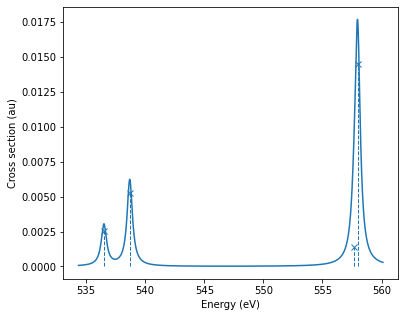

In [6]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Construct structure and basis objects
struct = gator.get_molecule(water_xyz)
basis = gator.get_molecular_basis(struct, '6-31G')

# Perform SCF calculation
scf_gs = gator.run_scf(struct,basis)

# Calculate the 6 lowest eigenstates with CVS restriction to MO #1 (oxygen 1s)
adc_res = gator.run_adc(struct, basis, scf_gs, method='cvs-adc2x', singlets=4, core_orbitals=1)

+--------------------------------------------------------------+
| cvs-adc2x                               singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.71638      536.5099   0.0175       0.8       0.2  |
|  1       19.7967      538.6956   0.0368    0.8087    0.1913  |
|  2      20.49351      557.6567   0.0098    0.7858    0.2142  |
|  3      20.50482      557.9647   0.1007    0.8441    0.1559  |
+--------------------------------------------------------------+



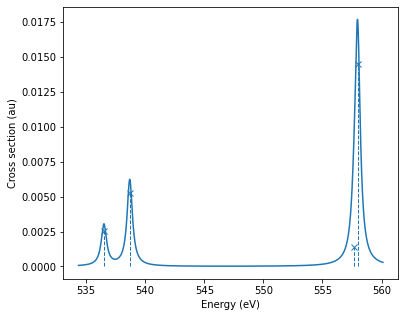

In [7]:
# Print information on eigenstates
print(adc_res.describe())

plt.figure(figsize=(6,5))
# Convolute using functionalities available in gator and adcc
adc_res.plot_spectrum()
plt.show()

### CPP-DFT

## XES

### ADC

In [8]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = '6-31G'
mol.build()

# Perform unrestricted SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy molecular orbitals
mo0 = copy.deepcopy(scf_res.mo_coeff)
occ0 = copy.deepcopy(scf_res.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0

# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Perform ADC calculation
adc_xes = adcc.adc2(scf_ion, n_states = 4)

converged SCF energy = -75.9838703827193  <S^2> = 6.3389294e-12  2S+1 = 1
converged SCF energy = -56.0754789470865  <S^2> = 0.76257805  2S+1 = 2.0125387
Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.77768   1.6s  [-19.29082067 -19.19940205 -18.96181907 -18.3637012 ]
  2    16     0.0010764  214ms  [-19.44427093 -19.36689642 -19.16826546 -18.57947501]
  3    24    4.4301e-07  302ms  [-19.44429764 -19.3669284  -19.16831914 -18.57954987]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             2s 114ms


+--------------------------------------------------------------+
| adc2                                        any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      -19.4443     -529.1063   0.0568    0.9548    0.0452  |
|  1     -19.36693      -527.001   0.0458    0.9503   0.04966  |
|  2     -19.16832     -521.5965   0.0419    0.9376   0.06245  |
|  3     -18.57955     -505.5753   0.0031    0.9335   0.06655  |
+--------------------------------------------------------------+



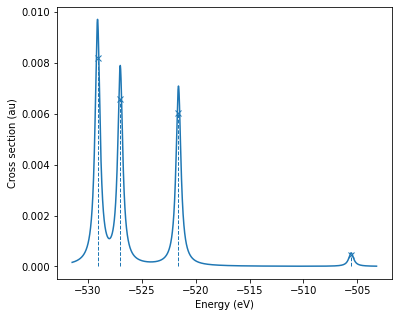

In [9]:
# Print information on eigenstates
print(adc_xes.describe())

plt.figure(figsize=(6,5))
# Convolute using functionalities available in gator and adcc
adc_xes.plot_spectrum()
plt.show()